# Visualizing Thinc models (with shape inference)

This is a simple notebook showing how you can easily visualize your Thinc models and their inputs and outputs using [Graphviz](https://www.graphviz.org/) and [`pydot`](https://github.com/pydot/pydot). If you're installing `pydot` via the notebook, make sure to restart your kernel (or Google Colab VM – [see here](https://stackoverflow.com/questions/49853303/how-to-install-pydot-graphviz-on-google-colab) for details) after installation.

In [ ]:
!pip install "thinc>=8.0.0a0" pydot graphviz svgwrite

Let's start by defining a model with a number of layers chained together using the `chain` combinator:

In [83]:
from thinc.api import chain, expand_window, Relu, Maxout, Linear, Softmax

n_hidden = 32
dropout = 0.2

model= chain(
    expand_window(3),
    Relu(nO=n_hidden, dropout=dropout, normalize=True),
    Maxout(nO=n_hidden * 4),
    Linear(nO=n_hidden * 2),
    Relu(nO=n_hidden, dropout=dropout, normalize=True),
    Linear(nO=n_hidden),
    Relu(nO=n_hidden, dropout=dropout),
    Softmax(),
)

Here's the visualization we want to achieve for this model: the **name of the layer** or combination of layers and the **input and output dimensions**. Note that `>>` refers to a chaining of layers.

![](https://user-images.githubusercontent.com/13643239/72763790-b8ab3900-3be5-11ea-8ea7-91e4e9fbb181.png)

This means we need to add a node for each layer, edges connecting the nodes to the previous node (except for the first/last), and labels like `"name|(nO,nI)"` – for instance, `"maxout|(128,32)"`. Here's a simple function that takes a Thinc layer (i.e. a `Model` instance) and returns a label with the layer name and its dimensions, if available:

In [84]:
def get_label(layer):
    layer_name = layer.name
    nO = layer.get_dim("nO") if layer.has_dim("nO") else "?"
    nI = layer.get_dim("nI") if layer.has_dim("nI") else "?"
    return f"{layer.name}|({nO}, {nI})".replace(">", "&gt;")

We can now use `pydot` to create a visualization for a given model. You can customize the direction of the notes by setting `"rankdir"` (e.g. `"TB"` for "top to bottom") and adjust the font and arrow styling. To make the visualization render nicely in a notebook, we can call into IPython's utilities.

In [85]:
import pydot
from IPython.display import SVG, display

def visualize_model(model):
    dot = pydot.Dot()
    dot.set("rankdir", "LR")
    dot.set_node_defaults(shape="record", fontname="arial", fontsize="10")
    dot.set_edge_defaults(arrowsize="0.7")
    nodes = {}
    for i, layer in enumerate(model.layers):
        label = get_label(layer)
        node = pydot.Node(layer.id, label=label)
        dot.add_node(node)
        nodes[layer.id] = node
        if i == 0:
            continue
        from_node = nodes[model.layers[i - 1].id]
        to_node = nodes[layer.id]
        if not dot.get_edge(from_node, to_node):
            dot.add_edge(pydot.Edge(from_node, to_node))
    display(SVG(dot.create_svg()))

Calling `visualize_model` on the model defined above will render the visualization. However, most dimensions will now show up as `(?, ?)`, instead of the *actual* dimensions as shown in the graph above. That's because Thinc allows **defining models with missing shapes** and is able to **infer the missing shapes from the data** when you call `model.initialize`. The model visualized here doesn't define all its shapes, so the labels are incomplete.

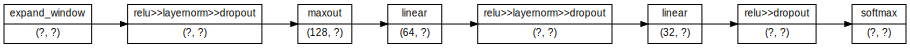

In [86]:
visualize_model(model)

To fill in the missing shapes, we can call `model.initialize` with examples of the expected input `X` and output `Y`. Running `visualize_model` again now shows the complete shapes.

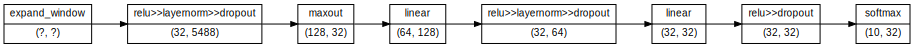

In [87]:
import numpy

X = numpy.zeros((5, 784), dtype="f")
Y = numpy.zeros((54000, 10), dtype="f")
model.initialize(X=X, Y=Y)

visualize_model(model)